Бинарная классификация:
1. Терминал с дефектом
2. Терминал без дефекта

В датасете есть аугментированные картинки с дефектом.

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import os
from sklearn.model_selection import train_test_split
import shutil
import gc
import random
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from PIL import ImageFile

In [2]:
RANDOM_STATE = 42

seed = RANDOM_STATE
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Подготовка датасета

In [5]:
df = pd.read_pickle('../data/common_files/df_markup.pkl')
df = df.loc[
    (df['terminal']==1) &
    (df['terminal_unrecognized_defect']==0)
]
# df['file_name'] = df['file_name'].apply(lambda x: x.split('..\\data\\')[1].replace('\\', '/'))

In [6]:
from PIL import UnidentifiedImageError

for file in tqdm(df['file_name']):
    try:
        img = Image.open(file)
    except UnidentifiedImageError:
        df = df[df['file_name']!=file]

100%|██████████| 15616/15616 [00:00<00:00, 16864.92it/s]


In [7]:
df['terminal_damaged'].value_counts()

terminal_damaged
1    12874
0     2742
Name: count, dtype: int64

terminal_damaged:	0


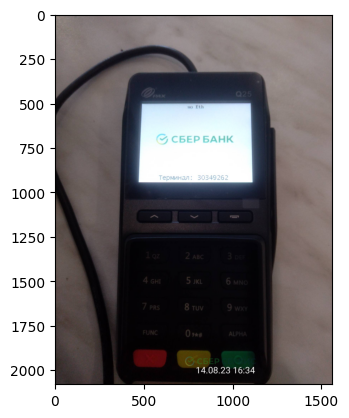

terminal_damaged:	1


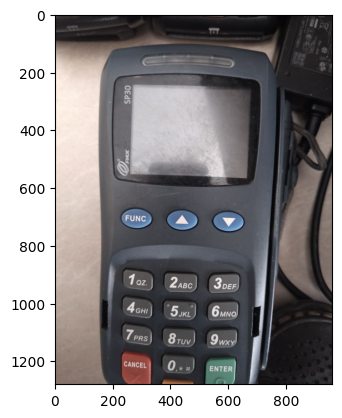

terminal_damaged:	1


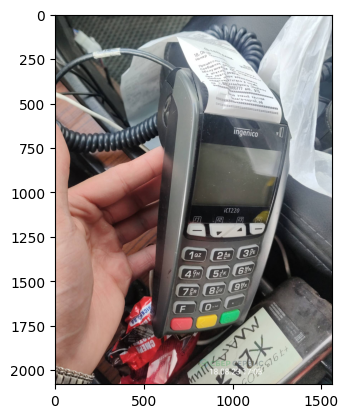

terminal_damaged:	1


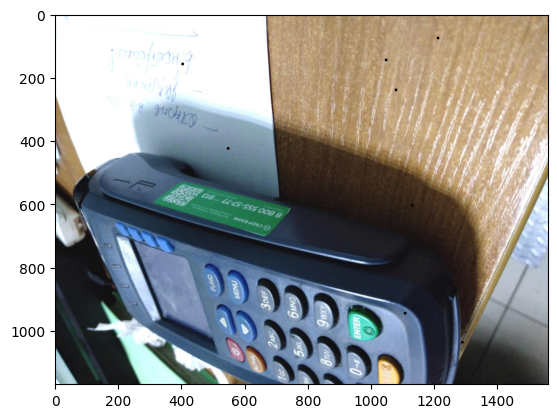

terminal_damaged:	1


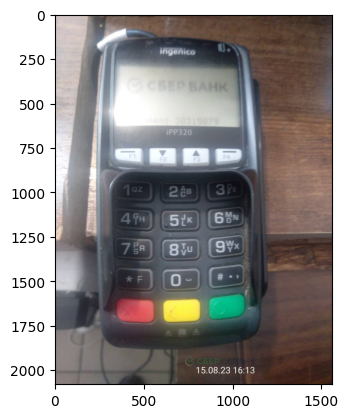

In [8]:
for row in df.sample(5).iterrows():
    row = row[1]
    img = Image.open(row['file_name'])
    print(f'terminal_damaged:\t{row["terminal_damaged"]}')
    plt.imshow(img)
    plt.show()

In [9]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [10]:
train_data_augmented_damaged = df[df['file_name'].apply(lambda x: 'damaged_augm' in x)]

df_not_augm = df.loc[list(set(df.index) - set(train_data_augmented_damaged.index))]

df_not_augm_damaged = df_not_augm.loc[
    df_not_augm['terminal_damaged']==1
]
df_not_augm_dam_train = df_not_augm_damaged.sample(df_not_augm_damaged.shape[0]//2, random_state=RANDOM_STATE)
df_not_augm_dam_test = df_not_augm_damaged.loc[
    list(set(df_not_augm_damaged.index)-set(df_not_augm_dam_train.index))
]

df_not_augm_undam = df_not_augm.loc[
    df_not_augm['terminal_damaged']==0
]
df_not_augm_undam_train = df_not_augm_undam.sample(df_not_augm_undam.shape[0]//2, random_state=RANDOM_STATE)
df_not_augm_undam_test = df_not_augm_undam.loc[
    list(set(df_not_augm_undam.index)-set(df_not_augm_undam_train.index))
]

train_data = pd.concat(
    (train_data_augmented_damaged, df_not_augm_dam_train, df_not_augm_undam_train)
)
test_data = pd.concat(
    (df_not_augm_dam_test, df_not_augm_undam_test)
)

In [11]:
train_data['terminal_damaged'].value_counts()

terminal_damaged
1    12242
0     1371
Name: count, dtype: int64

In [12]:
test_data['terminal_damaged'].value_counts()

terminal_damaged
0    1371
1     632
Name: count, dtype: int64

In [13]:
train_data['file_name'].apply(lambda x: 'damaged_augm' in x).sum()

11610

In [14]:
test_data['file_name'].apply(lambda x: 'damaged_augm' in x).sum()

0

In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column, transform=None, filename=False):
        self.data = dataframe
        self.transform = transform
        self.target_column = target_column
        self.filename = filename

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx][self.target_column]
        file_name = self.data.iloc[idx]['file_name']
        img = Image.open(file_name).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.filename:
            return img, label, file_name
        return img, label

In [16]:
NUM_WORKERS = 0
BATCH_SIZE = 32

train_dataset = CustomDataset(train_data, target_column='terminal_damaged', transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataset = CustomDataset(test_data, target_column='terminal_damaged', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Обучение модели

In [17]:
models_dir = 'models_quality_resnetx'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [18]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses,
            test_losses,
            train_accuracies,
            test_accuracies,
            train_f1s,
            test_f1s,
            train_precisions,
            test_precisions,
            train_recalls,
            test_recalls):
    clear_output()
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    plt.rcParams['font.size'] = '12'
    axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label='train', marker='o')
    axs[0, 0].plot(range(1, len(test_losses) + 1), test_losses, label='test', marker='o')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train', marker='o')
    axs[0, 1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test', marker='o')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    axs[0, 2].plot(range(1, len(train_f1s) + 1), train_f1s, label='train', marker='o')
    axs[0, 2].plot(range(1, len(test_f1s) + 1), test_f1s, label='test', marker='o')
    axs[0, 2].set_ylabel('F1')
    axs[0, 2].legend()

    axs[1, 0].plot(range(1, len(train_precisions) + 1), train_precisions, label='train', marker='o')
    axs[1, 0].plot(range(1, len(test_precisions) + 1), test_precisions, label='test', marker='o')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].legend()

    axs[1, 1].plot(range(1, len(train_recalls) + 1), train_recalls, label='train', marker='o')
    axs[1, 1].plot(range(1, len(test_recalls) + 1), test_recalls, label='test', marker='o')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].legend()

    # for ax in axs:
    #     ax.set_xlabel('epoch')
    #     ax.legend()
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy, train_f1, train_precision, train_recall = 0.0, 0.0, 0.0, 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        train_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        train_precision += precision_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        train_recall += recall_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_f1 /= len(train_loader)
    train_precision /= len(train_loader)
    train_recall /= len(train_loader)

    return train_loss, train_accuracy, train_f1, train_precision, train_recall


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy, test_f1, test_precision, test_recall = 0.0, 0.0, 0.0, 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        test_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        test_precision += precision_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        test_recall += recall_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_f1 /= len(test_loader)
    test_precision /= len(test_loader)
    test_recall /= len(test_loader)

    return test_loss, test_accuracy, test_f1, test_precision, test_recall


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies, train_f1s, train_precisions, train_recalls = [], [], [], [], []
    test_losses, test_accuracies, test_f1s, test_precisions, test_recalls = [], [], [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy, train_f1, train_precision, train_recall = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy, test_f1, test_precision, test_recall = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        train_f1s += [train_f1]
        train_precisions += [train_precision]
        train_recalls += [train_recall]

        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        test_f1s += [test_f1]
        test_precisions += [test_precision]
        test_recalls += [test_recall]
        plot_losses(
            train_losses,
            test_losses,
            train_accuracies,
            test_accuracies,
            train_f1s,
            test_f1s,
            train_precisions,
            test_precisions,
            train_recalls,
            test_recalls
          )
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses[-1],
            'test_loss': test_losses[-1],
            'train_accuracy': train_accuracies[-1],
            'test_accuracy': test_accuracies[-1],
            'train_f1': train_f1s[-1],
            'test_f1': test_f1s[-1],
            'train_precision': train_precisions[-1],
            'test_precision': test_precisions[-1],
            'train_recall': train_recalls[-1],
            'test_recall': test_recalls[-1]
        }, models_dir+f'/model_terminal_quality_ep{epoch}.pth')

    return train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s, train_precisions, test_precisions, train_recalls, test_recalls

In [19]:
model_terminal = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resneXt')
model_terminal.eval()
model_terminal = model_terminal.to(device)
model_terminal.fc = nn.Linear(2048, 2, device=device)

Using cache found in C:\Users\Dm/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\Dm/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\Dm/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [20]:
num_epochs = 30

optimizer = torch.optim.SGD(model_terminal.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [21]:
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s, train_precisions, test_precisions, train_recalls, test_recalls = train(
    model_terminal, optimizer, scheduler, criterion, train_dataloader, test_dataloader, num_epochs
)

Training 1/30:   0%|          | 2/426 [00:05<15:58,  2.26s/it]C:\Users\Dm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training 1/30:   1%|          | 3/426 [00:05<11:17,  1.60s/it]C:\Users\Dm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training 1/30:   1%|          | 4/426 [00:06<08:57,  1.27s/it]C:\Users\Dm\AppData\Loca

In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model_terminal, models_dir+'/model_quality_binary_augm_resnetx.pt')

# Валидация

In [ ]:
test_dataset = CustomDataset(test_data, target_column='terminal_damaged', transform=test_transforms, filename=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [ ]:
all_labels, all_preds_terminal, all_logits, filenames = [], [], [], []
model_terminal.eval()
for images, labels, filename in tqdm(test_dataloader):
    images = images.to(device)  # images: batch_size x num_channels x height x width
    with torch.no_grad():
        logits_terminal = model_terminal(images)  # logits: batch_size x num_classes
    predictions_terminal = logits_terminal.argmax(dim=1)

    all_logits.append(logits_terminal)
    all_labels.append(labels)
    all_preds_terminal.append(predictions_terminal)
    filenames.append(filenames)
    del (
        images, logits_terminal, predictions_terminal, filename
    )

In [ ]:
all_preds_terminal = [torch.Tensor.cpu(x).numpy() for x in all_preds_terminal]
df_val = pd.DataFrame({
    'labels': np.hstack(all_labels),
    'predictions_terminal': np.hstack(all_preds_terminal)
})
df_val.head()

In [ ]:
from sklearn.metrics import confusion_matrix

df_val = df_val[['labels', 'predictions_terminal']]
cm = confusion_matrix(
    df_val['labels'],
    df_val['predictions_terminal'],
    labels=[0, 1]
)

# Define class labels
class_names = ['Терминал без дефекта', 'Терминал с дефектом']
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Прогнозы модели')
plt.ylabel('Настоящие метки')
plt.show()

In [ ]:
print(classification_report(    df_val['labels'],
    df_val['predictions_terminal']))